In [1]:
import linecache
import os
import pandas as pd
import torch
from tqdm import tqdm
import re
import ast
from matplotlib import pyplot as plt
import numpy as np
# from tqdm import tqdm  # 导入 tqdm 库
# from tqdm.notebook import tqdm  # 使用适用于 Jupyter Notebook 的 tqdm 版本

In [2]:
def ExtractLogSpectra(log_path: str, issues: list):  
    """
    从一个log文件中获取红外光谱的 freqs, intens信息
    """
    freqs = []
    intens = []
    activs = []
    pattern_space = r"\s+"
    lines = linecache.getlines(log_path)
    meet_info = False
    non_numeric_activs = False  # 标记是否存在非数值形式的 activs
    
    for line in lines:
        line = line.strip()
        if line.startswith('Harmonic frequencies'):
            meet_info = True
            continue  # 跳到下一行
        if not meet_info:
            continue
        if line.startswith("Frequencies --"):
            for freq in re.split(pattern_space, line)[2:]:
                try:
                    freqs.append(float(freq))
                except ValueError:
                    issues.append(f"文件 {log_path} 中存在非数值形式的频率值: '{freq}'")
        elif line.startswith("IR Inten    --"):
            for inten in re.split(pattern_space, line)[3:]:
                try:
                    intens.append(float(inten))
                except ValueError:
                    issues.append(f"文件 {log_path} 中存在非数值形式的强度值: '{inten}'")
    return freqs, intens

#### 365个log中没有发现非数值形式的信息，接下来进行展宽

In [4]:
def lor_process(fs: [float], ins: [float], sigma: float = 5.0):
    """对提取的freqs,intens, activs的光谱信息进行展宽处理"""
    fs = torch.tensor(fs, dtype=torch.float)
#     print("fs.shape:\t", fs.shape)
    ins = torch.tensor(ins, dtype=torch.float)
#     print(("ins.shape；\t", ins.shape))
    new_x = torch.linspace(400, 4000, 3600)  # 800-4000  对应实验数据，去除最后一个为0的点，共3329个点
    lx = fs[:, None] - new_x[None, :]
#     print("lx.shape；\t", lx.shape)
    ly = sigma / (lx ** 2 + sigma ** 2)
#     print("ly.shape:\t", ly.shape)
    maxm = torch.max(ly)
#     print("torch.max(ly)；\t", maxm)
    new_y = torch.sum(ins[:, None] * ly / maxm, dim=0)
    new_y = new_y.tolist()
    new_x = new_x.tolist()
    return new_x, new_y

In [6]:
'''展示其中一个文件的信息，设置合适的展宽数值，sigma越小，线宽越小，信息就就更易于显示'''
# log_file_path = './data/logs/a1.log'
log_file_path = './test-model-perfermance/logs/E1.log'
freqs, intens = ExtractLogSpectra(log_file_path, None)
# freqs, intens, activs = ExtractLogSpectra(log_file_path, None)
new_freqs_1, new_intens = lor_process(freqs, intens)
# new_freqs_2, new_activs = lor_process(freqs, activs)

In [7]:
# new_freqs_1 == new_freqs_2  # 展宽的频率是一样的

In [8]:
# intens[:10], activs[:10]

(400.0, 4000.0, -29.96205075085163, 425.5035400390625)

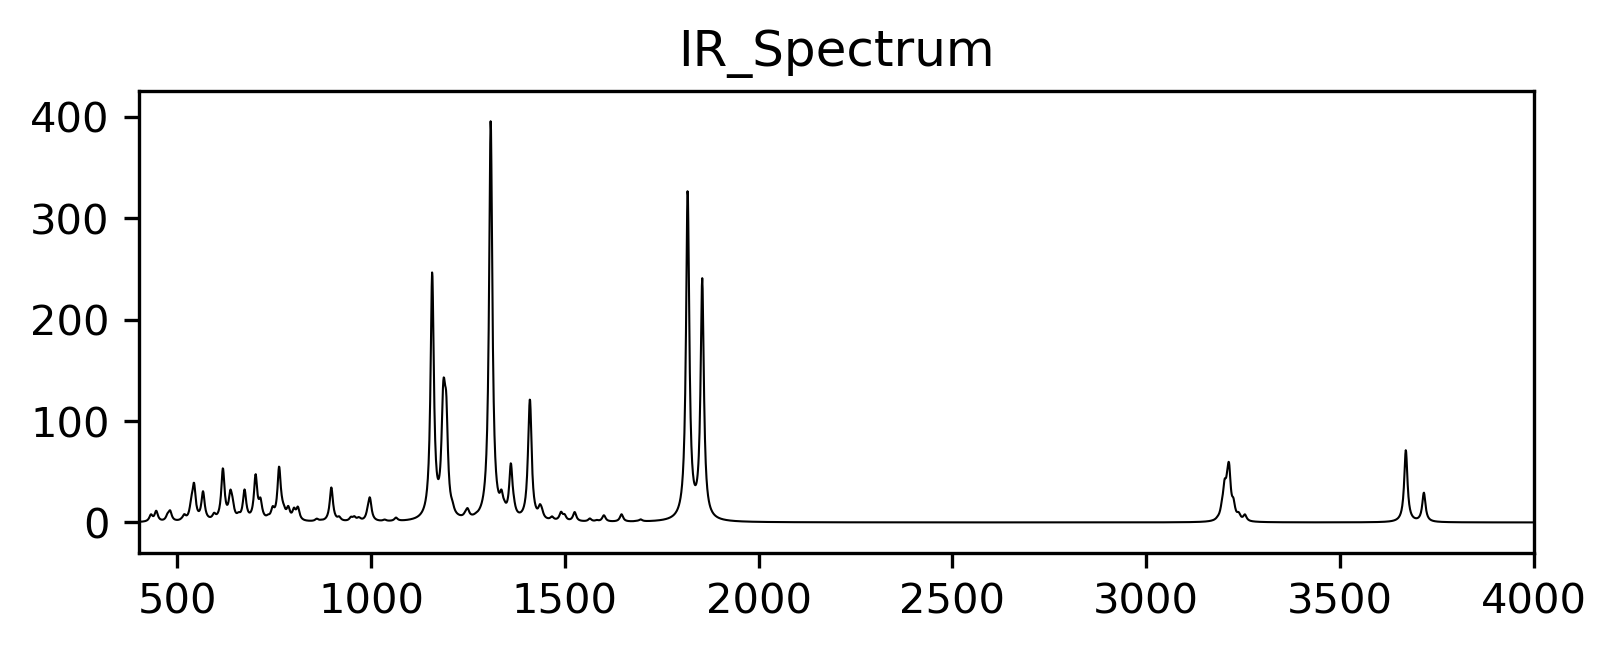

In [9]:
'''展示其中一个文件进行plot'''
figsize = (6, 2)

plt.figure(1, figsize=figsize, dpi=300)
plt.plot(new_freqs_1, new_intens, linewidth=0.5, c='k')
plt.title("IR_Spectrum")
# plt.xticks([1000, 2000, 3000, 3900])
# plt.xticks([])
# plt.yticks([])  # 清空 y 轴刻度
plt.axis([min(new_freqs_1), max(new_freqs_1), min(new_intens)-30, max(new_intens)+30])

# plt.figure(2, figsize=figsize, dpi=300)
# plt.plot(new_freqs, new_activs, linewidth=0.5, c='r')
# plt.title("Raman_Spectrum")
# # plt.xticks([1000, 2000, 3000, 3900])
# # plt.xticks([])
# # plt.yticks([])  # 清空 y 轴刻度
# plt.axis([min(new_freqs), max(new_freqs), min(new_activs)-30, max(new_activs)+30])

In [10]:
def normalize_spectrum(log, label, data):
    """
    对光谱数据进行归一化处理，将数据缩放到 [0, 1] 范围内。
    参数： data (list or np.array): 原始光谱数据。    
    返回： np.array: 归一化后的光谱数据。
    """
    data = np.array(data)
    max_val = np.max(data)
    if max_val == 0:
        print(f'{log}-{label}数值：np.max(data)==0')
        return data  # 避免除以零
    return data / max_val

In [11]:
def SaveLogInfoProcess(path, save_path):
    """从目录下批量提取log文件中信息：
    1. 红外光谱
    """
    logs = [f for f in os.listdir(path) if f.endswith(".log")]
    log_paths = [os.path.join(path, log) for log in logs]  # 获取每个文件的路径
    
    spectra_data = []  # 用于收集所有文件的光谱信息
    issues = []        # 用于记录所有问题
#     spectra_df = pd.DataFrame(columns=["Filename", "freqs", "IR_intens", "Raman_activs"])  # 构建一个保存展宽后光谱信息的df
    with tqdm(total=len(log_paths), desc="Processing log files", unit="file") as pbar:  
        for log,log_path in zip(logs, log_paths):
            pbar.update(1)
            try:
                freqs, intens = ExtractLogSpectra(log_path, None)  # 提取log信息
                ir_freqs, ir_intens = lor_process(freqs, intens)             # 红外展宽处理
                
                # 归一化处理
                ir_intens_normalized = normalize_spectrum(log,'ir', ir_intens)
                
                # 收集当前文件的光谱信息
                spectra_data.append({
                    "Filename": log,
                    "freqs": ir_freqs,
                    "IR_intens": ir_intens,
                })
            except Exception as e:
                issues.append(f"文件 {log_path} 处理时发生异常: {e}")
                
    # 创建 DataFrame
    spectra_df = pd.DataFrame(spectra_data, columns=["Filename", "freqs", "IR_intens"])
    # 保存到CSV文件
    spectra_df.to_csv(save_path, sep="\t", encoding="utf-8", index=False)   
    # 处理完成后，统一输出所有问题

In [28]:
base_path = './data/'
log_path = os.path.join(base_path, 'logs') 
save_path = os.path.join(base_path, 'IrSpecInfo.csv') 
SaveLogInfoProcess(log_path, save_path)

Processing log files: 100%|███████████████████████████████████████████████████████| 365/365 [00:03<00:00, 121.14file/s]


In [13]:
base_path = './test-model-perfermance/'
log_path = os.path.join(base_path, 'logs') 
save_path = os.path.join(base_path, 'IrSpecInfo.csv') 
SaveLogInfoProcess(log_path, save_path)

Processing log files: 100%|██████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 75.21file/s]


## expand

In [32]:
# ir_df = pd.read_csv('./data/3.1IrSpecInfo.csv', sep="\t")
ir_df = pd.read_csv('./test-model-perfermance/data/3.IrSpecInfo.csv', sep="\t")
# 定义需要解析的列
list_columns = ["freqs", "IR_intens"]
# 使用 ast.literal_eval 解析字符串形式的列表
for col in list_columns:
    ir_df[col] = ir_df[col].apply(ast.literal_eval)

In [33]:
ir_df['Filename'] = ir_df['Filename'].str.replace('.log', '', regex=True)
ir_df.head()

,Filename,freqs,IR_intens
0,a1,"[400.0, 401.0002746582031, 402.00054931640625,...","[0.33947932720184326, 0.3590356409549713, 0.38..."
1,a100,"[400.0, 401.0002746582031, 402.00054931640625,...","[1.8867021799087524, 1.6558873653411865, 1.468..."
2,a101,"[400.0, 401.0002746582031, 402.00054931640625,...","[0.32412540912628174, 0.3455284833908081, 0.36..."
3,a102,"[400.0, 401.0002746582031, 402.00054931640625,...","[3.343003034591675, 2.8865854740142822, 2.5087..."
4,a103,"[400.0, 401.0002746582031, 402.00054931640625,...","[5.429183483123779, 4.766148567199707, 4.22463..."


In [34]:
def expand_list_column_with_filename(df, column_name, prefix):
    """
    将包含列表的列展开为多个独立的列，并添加指定的前缀，同时保留 'Filename' 列。
    参数：df (pd.DataFrame): 原始 DataFrame。column_name (str): 要展开的列名。prefix (str): 新列的前缀。
    返回：pd.DataFrame: 展开的新列 DataFrame。
    """
    # 确保所有列表长度相同
    list_lengths = df[column_name].apply(len).unique()
    if len(list_lengths) != 1:
        raise ValueError(f"列 {column_name} 中存在不同长度的列表: {list_lengths}")
    list_length = list_lengths[0]
    # 生成新的列名
    new_columns = [f"{prefix}_{i}" for i in range(list_length)]
    
    # 将列表列转换为 DataFrame
    expanded_df = pd.DataFrame(df[column_name].tolist(), 
                               columns=new_columns,
                               index=df.index)
    # 添加 'Filename' 列
    expanded_df = pd.concat([df['Filename'], expanded_df], axis=1)
    return expanded_df

In [35]:
# 展开 IR_intens 和 Raman_activs 列
ir_expanded_2 = expand_list_column_with_filename(ir_df, "IR_intens", "ir")
ir_expanded_2.head()

,Filename,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
0,a1,0.339479,0.359036,0.381642,0.408118,0.439519,0.477208,0.522939,0.578967,0.648067,...,0.019863,0.019816,0.019769,0.019722,0.019675,0.019628,0.019582,0.019536,0.019490,0.019444
1,a100,1.886702,1.655887,1.468721,1.312900,1.179713,1.064340,0.964522,0.878713,0.805245,...,0.012729,0.012708,0.012687,0.012666,0.012645,0.012624,0.012603,0.012582,0.012561,0.012541
2,a101,0.324125,0.345528,0.369781,0.397417,0.429096,0.465648,0.508115,0.557828,0.616500,...,0.010453,0.010434,0.010414,0.010395,0.010376,0.010357,0.010338,0.010319,0.010300,0.010282
3,a102,3.343003,2.886585,2.508772,2.201483,1.952241,1.749055,1.581960,1.443117,1.326516,...,0.016775,0.016752,0.016728,0.016705,0.016682,0.016659,0.016636,0.016613,0.016590,0.016567
4,a103,5.429183,4.766149,4.224635,3.780324,3.415107,3.115441,2.870939,2.672667,2.511015,...,0.014954,0.014932,0.014910,0.014888,0.014866,0.014844,0.014822,0.014800,0.014778,0.014756


In [38]:
ir_expanded_2.to_csv('data/3.1ir_expanded.csv', index=False)

In [39]:
from sklearn.preprocessing import StandardScaler

In [43]:
ir_expanded_without_fn_2 = ir_expanded_2.drop(['Filename'], axis=1)
ir_expanded_without_fn_2.head()

,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,ir_9,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
0,0.339479,0.359036,0.381642,0.408118,0.439519,0.477208,0.522939,0.578967,0.648067,0.733351,...,0.019863,0.019816,0.019769,0.019722,0.019675,0.019628,0.019582,0.019536,0.019490,0.019444
1,1.886702,1.655887,1.468721,1.312900,1.179713,1.064340,0.964522,0.878713,0.805245,0.742329,...,0.012729,0.012708,0.012687,0.012666,0.012645,0.012624,0.012603,0.012582,0.012561,0.012541
2,0.324125,0.345528,0.369781,0.397417,0.429096,0.465648,0.508115,0.557828,0.616500,0.686347,...,0.010453,0.010434,0.010414,0.010395,0.010376,0.010357,0.010338,0.010319,0.010300,0.010282
3,3.343003,2.886585,2.508772,2.201483,1.952241,1.749055,1.581960,1.443117,1.326516,1.227581,...,0.016775,0.016752,0.016728,0.016705,0.016682,0.016659,0.016636,0.016613,0.016590,0.016567
4,5.429183,4.766149,4.224635,3.780324,3.415107,3.115441,2.870939,2.672667,2.511015,2.373359,...,0.014954,0.014932,0.014910,0.014888,0.014866,0.014844,0.014822,0.014800,0.014778,0.014756


In [44]:
scaler = StandardScaler()
ir_expanded_without_fn_scaled_2 = pd.DataFrame(scaler.fit_transform(ir_expanded_without_fn_2),
                                             columns=ir_expanded_without_fn_2.columns, 
                                             index=ir_expanded_without_fn_2.index)
ir_expanded_without_fn_scaled_2.head()

,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,ir_9,...,ir_3590,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599
0,-0.477847,-0.458806,-0.434374,-0.407671,-0.382519,-0.362808,-0.350572,-0.344591,-0.340983,-0.336058,...,-0.396394,-0.396711,-0.397027,-0.397342,-0.397657,-0.397970,-0.398282,-0.398593,-0.398903,-0.399212
1,-0.272467,-0.295190,-0.306275,-0.309276,-0.308401,-0.307997,-0.311146,-0.318274,-0.327171,-0.335264,...,-0.606986,-0.607491,-0.607989,-0.608482,-0.608968,-0.609448,-0.609922,-0.610391,-0.610853,-0.611309
2,-0.479885,-0.460511,-0.435772,-0.408835,-0.383562,-0.363887,-0.351895,-0.346447,-0.343757,-0.340213,...,-0.674165,-0.674921,-0.675670,-0.676412,-0.677147,-0.677875,-0.678597,-0.679311,-0.680018,-0.680719
3,-0.079156,-0.139921,-0.183717,-0.212642,-0.231045,-0.244077,-0.256018,-0.268722,-0.281364,-0.292367,...,-0.487559,-0.487581,-0.487598,-0.487610,-0.487617,-0.487620,-0.487618,-0.487612,-0.487601,-0.487585
4,0.197766,0.097213,0.018477,-0.040943,-0.084563,-0.116520,-0.140934,-0.160772,-0.177276,-0.191079,...,-0.541292,-0.541529,-0.541761,-0.541987,-0.542207,-0.542423,-0.542633,-0.542838,-0.543038,-0.543232


In [45]:
ir_expanded_scaled_2 = ir_expanded_without_fn_scaled_2.join(ir_expanded_2['Filename'])
ir_expanded_scaled_2.head()

,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,ir_9,...,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599,Filename
0,-0.477847,-0.458806,-0.434374,-0.407671,-0.382519,-0.362808,-0.350572,-0.344591,-0.340983,-0.336058,...,-0.396711,-0.397027,-0.397342,-0.397657,-0.397970,-0.398282,-0.398593,-0.398903,-0.399212,a1
1,-0.272467,-0.295190,-0.306275,-0.309276,-0.308401,-0.307997,-0.311146,-0.318274,-0.327171,-0.335264,...,-0.607491,-0.607989,-0.608482,-0.608968,-0.609448,-0.609922,-0.610391,-0.610853,-0.611309,a100
2,-0.479885,-0.460511,-0.435772,-0.408835,-0.383562,-0.363887,-0.351895,-0.346447,-0.343757,-0.340213,...,-0.674921,-0.675670,-0.676412,-0.677147,-0.677875,-0.678597,-0.679311,-0.680018,-0.680719,a101
3,-0.079156,-0.139921,-0.183717,-0.212642,-0.231045,-0.244077,-0.256018,-0.268722,-0.281364,-0.292367,...,-0.487581,-0.487598,-0.487610,-0.487617,-0.487620,-0.487618,-0.487612,-0.487601,-0.487585,a102
4,0.197766,0.097213,0.018477,-0.040943,-0.084563,-0.116520,-0.140934,-0.160772,-0.177276,-0.191079,...,-0.541529,-0.541761,-0.541987,-0.542207,-0.542423,-0.542633,-0.542838,-0.543038,-0.543232,a103


In [46]:
ir_spec_save_path = './data/'
ir_expanded_scaled_2.to_csv(os.path.join(ir_spec_save_path, 'ir_expanded_scaled_2.csv'), index=False)